# Robótica Móvel - Trabalho Prático 1 (Exercícios 1-4)
---
**Nome Completo:** Daniel Terra Gomes

**Matrícula:** 2025702870 

**Programa:** Mestrando do PPGCC  
**Departamento:** Departamento de Ciência da Computação  
**Instituição:** ICEx-UFMG  
**E-mail:** danielterragomes@ufmg.br

**Data:** 11 de setembro de 2025

---

Este notebook implementa os exercícios 1-4 do TP1, focando em:
- Criação de cenas no CoppeliaSim
- Sistemas de coordenadas e transformações
- Matrizes de transformação homogêneas
- Análise de poses relativas entre objetos

## Configuração Inicial e Importações

In [1]:
# Imports necessários
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Dict, List, Tuple, Optional

# Import das utilidades criadas para o TP1
from robotics_utils import (
    CoppeliaSimConnector,
    SceneAnalyzer,
    create_homogeneous_matrix,
    invert_homogeneous_matrix,
    plot_frame,
    DEFAULT_OBJECT_MAPPING_EX1_4,
    setup_simulation,
    wait_for_user_input,
    validate_transformation_matrix
)

print("Módulos importados com sucesso!")
print("Certifique-se de que o CoppeliaSim está rodando com a cena T1.ttt aberta.")

Módulos importados com sucesso!
Certifique-se de que o CoppeliaSim está rodando com a cena T1.ttt aberta.


## Exercício 1: Criação da Cena no CoppeliaSim

O primeiro passo foi criar uma cena no CoppeliaSim contendo um robô móvel (RobotnikSummitXL) e cinco outros objetos distintos para popular o ambiente de simulação.

**Objetos adicionados:**
- 1 Robô móvel: RobotnikSummitXL
- 2 Pessoas: Bill[0] e Bill[1]
- 1 Caixa: Floor/ConcretBlock
- 2 Pilares: Floor/20cmHighPillar10cm[0] e [1]
- 1 Mesa: diningTable
- 2 Laptops: diningTable/laptop[0] e [1]
- 2 Cercas: Floor/20cmHighWall100cm[0] e [1]

A cena foi salva como `T1.ttt` e deve estar carregada no CoppeliaSim para executar este notebook.

## Exercício 2: Diagrama de Transformações

O diagrama a seguir representa as relações entre os sistemas de coordenadas dos objetos na cena. O frame do Mundo {W} serve como referência global.

![Transformation Diagram](ex2-diagram.drawio.png)

*Figura: Diagrama de transformações mostrando os sistemas de coordenadas e as relações entre os diferentes frames na cena. As setas verdes representam transformações conhecidas, enquanto a seta vermelha mostra uma transformação desejada.*

**Conceitos importantes:**
- Cada objeto possui seu próprio sistema de coordenadas local
- O sistema mundial {W} é a referência global
- As transformações podem ser compostas para relacionar qualquer par de frames
- Utilizamos matrizes homogêneas 4x4 para representar posição e orientação

## Conexão com CoppeliaSim e Descoberta de Objetos

In [2]:
# Conectar ao CoppeliaSim
print("Conectando ao CoppeliaSim...")
connector = CoppeliaSimConnector()

if not connector.connect():
    raise RuntimeError("Falha na conexão com CoppeliaSim. Verifique se o simulador está rodando.")

# Descobrir objetos na cena
print("Descobrindo objetos na cena...")
object_handles = connector.discover_objects(DEFAULT_OBJECT_MAPPING_EX1_4)

if not object_handles:
    raise RuntimeError("Nenhum objeto encontrado. Verifique se a cena T1.ttt está carregada.")

print(f"\nObjetos descobertos: {list(object_handles.keys())}")

Conectando ao CoppeliaSim...
Successfully connected to CoppeliaSim
Descobrindo objetos na cena...
Discovered 11 objects:
  Robot: Handle 89
  Bill_0: Handle 56
  Bill_1: Handle 130
  Crate: Handle 25
  Pillar_0: Handle 29
  Pillar_1: Handle 49
  Table: Handle 118
  Laptop_0: Handle 122
  Laptop_1: Handle 126
  Fence_0: Handle 17
  Fence_1: Handle 21

Objetos descobertos: ['Robot', 'Bill_0', 'Bill_1', 'Crate', 'Pillar_0', 'Pillar_1', 'Table', 'Laptop_0', 'Laptop_1', 'Fence_0', 'Fence_1']
Discovered 11 objects:
  Robot: Handle 89
  Bill_0: Handle 56
  Bill_1: Handle 130
  Crate: Handle 25
  Pillar_0: Handle 29
  Pillar_1: Handle 49
  Table: Handle 118
  Laptop_0: Handle 122
  Laptop_1: Handle 126
  Fence_0: Handle 17
  Fence_1: Handle 21

Objetos descobertos: ['Robot', 'Bill_0', 'Bill_1', 'Crate', 'Pillar_0', 'Pillar_1', 'Table', 'Laptop_0', 'Laptop_1', 'Fence_0', 'Fence_1']


## Exercício 3: Matrizes de Transformação Homogêneas

Neste exercício, calculamos as matrizes de transformação homogêneas que representam as posições de todos os elementos da cena no referencial local do robô.

**Fundamentação teórica:**
- Matriz homogênea: $T = \begin{bmatrix} R & t \\ 0 & 1 \end{bmatrix}$
- $R$: matriz de rotação 3x3
- $t$: vetor de translação 3x1
- Transformação inversa: $T^{-1} = \begin{bmatrix} R^T & -R^T t \\ 0 & 1 \end{bmatrix}$

In [3]:
# Verificar pose inicial do robô
robot_pose = connector.get_object_pose('Robot')

if robot_pose:
    position, orientation = robot_pose
    print("Pose inicial do robô:")
    print(f"Posição (x, y, z): [{position[0]:.3f}, {position[1]:.3f}, {position[2]:.3f}] metros")
    print(f"Orientação (rx, ry, rz): [{orientation[0]:.3f}, {orientation[1]:.3f}, {orientation[2]:.3f}] radianos")

    # Converter para graus para melhor visualização
    orientation_deg = np.rad2deg(orientation)
    print(f"Orientação (rx, ry, rz): [{orientation_deg[0]:.1f}°, {orientation_deg[1]:.1f}°, {orientation_deg[2]:.1f}°]")
else:
    print("Erro: Não foi possível obter a pose do robô")

Pose inicial do robô:
Posição (x, y, z): [1.975, -1.875, 0.309] metros
Orientação (rx, ry, rz): [0.001, -0.000, 2.356] radianos
Orientação (rx, ry, rz): [0.1°, -0.0°, 135.0°]



=== Análise de Transformações - Exercício 3: Pose Inicial ===

Transformações calculadas para 10 objetos:

Bill_0:
  Posição no frame do robô: [-1.795, -2.818, -2.382] m
  Matriz válida: ✓

Bill_1:
  Posição no frame do robô: [0.230, -2.869, -2.433] m
  Matriz válida: ✓

Crate:
  Posição no frame do robô: [-3.969, -2.626, -2.897] m
  Matriz válida: ✓

Pillar_0:
  Posição no frame do robô: [-1.799, -0.644, -0.349] m
  Matriz válida: ✓

Pillar_1:
  Posição no frame do robô: [-1.021, -1.916, -1.621] m
  Matriz válida: ✓

Table:
  Posição no frame do robô: [-0.845, -2.658, -2.753] m
  Matriz válida: ✓

Laptop_0:
  Posição no frame do robô: [-1.095, -2.304, -3.038] m
  Matriz válida: ✓

Laptop_1:
  Posição no frame do robô: [-0.370, -2.338, -3.072] m
  Matriz válida: ✓

Fence_0:
  Posição no frame do robô: [-3.500, -0.098, 0.197] m
  Matriz válida: ✓

Fence_1:
  Posição no frame do robô: [-3.499, -0.770, -0.475] m
  Matriz válida: ✓


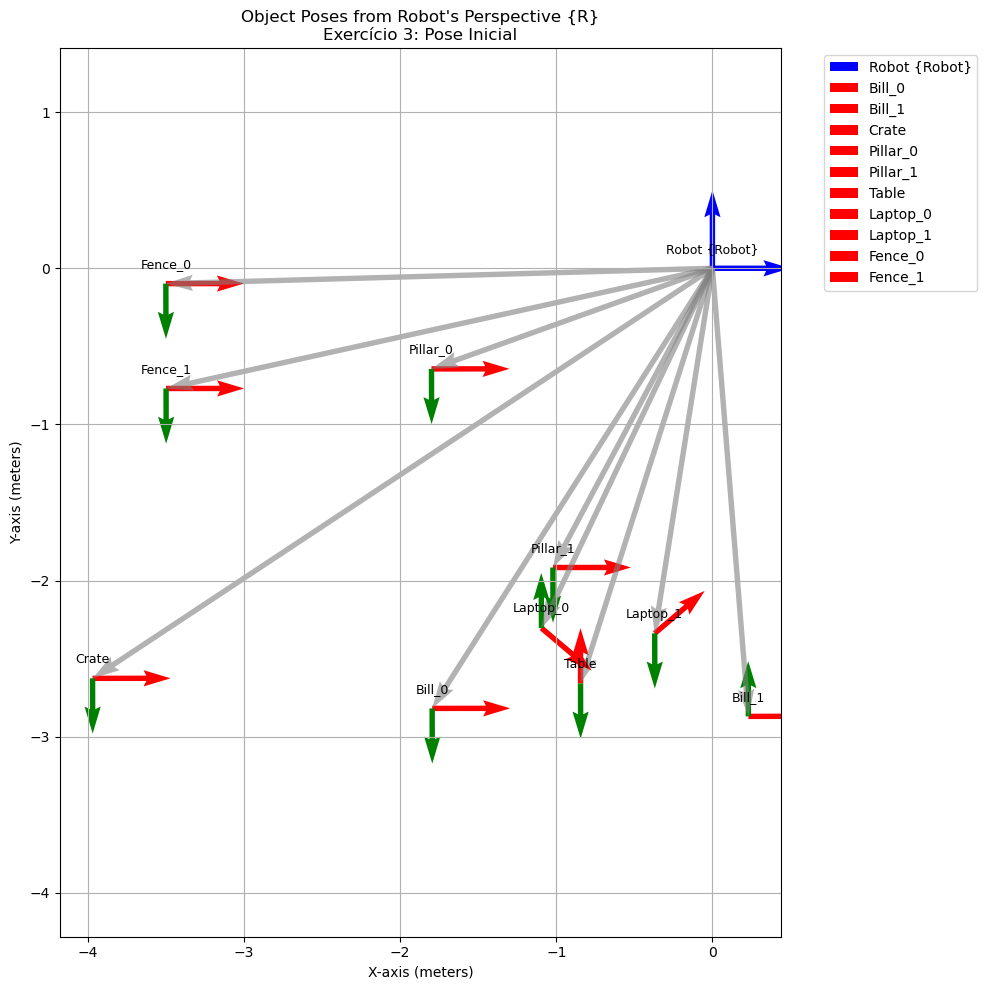

In [4]:
# Função para calcular e exibir transformações
def analyze_scene_transformations(connector, object_handles, scenario_name="Pose Inicial"):
    """
    Analisa e exibe as transformações entre objetos na cena.
    """
    print(f"\n=== Análise de Transformações - {scenario_name} ===")

    # Criar analisador de cena
    analyzer = SceneAnalyzer(connector)

    # Obter lista de objetos (excluindo o robô)
    object_names = [name for name in object_handles.keys() if name != 'Robot']

    # Calcular poses relativas
    relative_poses = analyzer.calculate_relative_poses('Robot', object_names)

    print(f"\nTransformações calculadas para {len(relative_poses)} objetos:")

    for obj_name, T_R_O in relative_poses.items():
        # Extrair posição e orientação no frame do robô
        pos_R = T_R_O[:3, 3]

        print(f"\n{obj_name}:")
        print(f"  Posição no frame do robô: [{pos_R[0]:.3f}, {pos_R[1]:.3f}, {pos_R[2]:.3f}] m")

        # Validar matriz de transformação
        is_valid = validate_transformation_matrix(T_R_O)
        print(f"  Matriz válida: {'✓' if is_valid else '✗'}")

    # Gerar plot
    analyzer.plot_scene_from_robot_perspective('Robot', object_names, scenario_name)

    return relative_poses

# Análise inicial
initial_poses = analyze_scene_transformations(connector, object_handles, "Exercício 3: Pose Inicial")

## Exercício 4: Múltiplas Posições do Robô

Neste exercício, colocamos o robô em três posições diferentes da cena e geramos os respectivos plots, verificando que a implementação funciona para diferentes casos. Variamos também a orientação do robô (frente, lado, costas) em relação aos elementos.

**Instruções:**
1. Mova o robô para diferentes posições na cena usando o CoppeliaSim
2. Execute as células abaixo após cada mudança de posição
3. Observe como as transformações se atualizam automaticamente

### Cenário A: Posição Lateral


CENÁRIO A: POSIÇÃO LATERAL
Mova o robô para uma posição lateral na cena e execute esta célula.

=== Análise de Transformações - Cenário A: Posição Lateral ===

Transformações calculadas para 10 objetos:

Bill_0:
  Posição no frame do robô: [-1.795, -2.818, -2.382] m
  Matriz válida: ✓

Bill_1:
  Posição no frame do robô: [0.230, -2.869, -2.433] m
  Matriz válida: ✓

Crate:
  Posição no frame do robô: [-3.969, -2.626, -2.897] m
  Matriz válida: ✓

Pillar_0:
  Posição no frame do robô: [-1.799, -0.644, -0.349] m
  Matriz válida: ✓

Pillar_1:
  Posição no frame do robô: [-1.021, -1.916, -1.621] m
  Matriz válida: ✓

Table:
  Posição no frame do robô: [-0.845, -2.658, -2.753] m
  Matriz válida: ✓

Laptop_0:
  Posição no frame do robô: [-1.095, -2.304, -3.038] m
  Matriz válida: ✓

Laptop_1:
  Posição no frame do robô: [-0.370, -2.338, -3.072] m
  Matriz válida: ✓

Fence_0:
  Posição no frame do robô: [-3.500, -0.098, 0.197] m
  Matriz válida: ✓

Fence_1:
  Posição no frame do robô: [-3.49

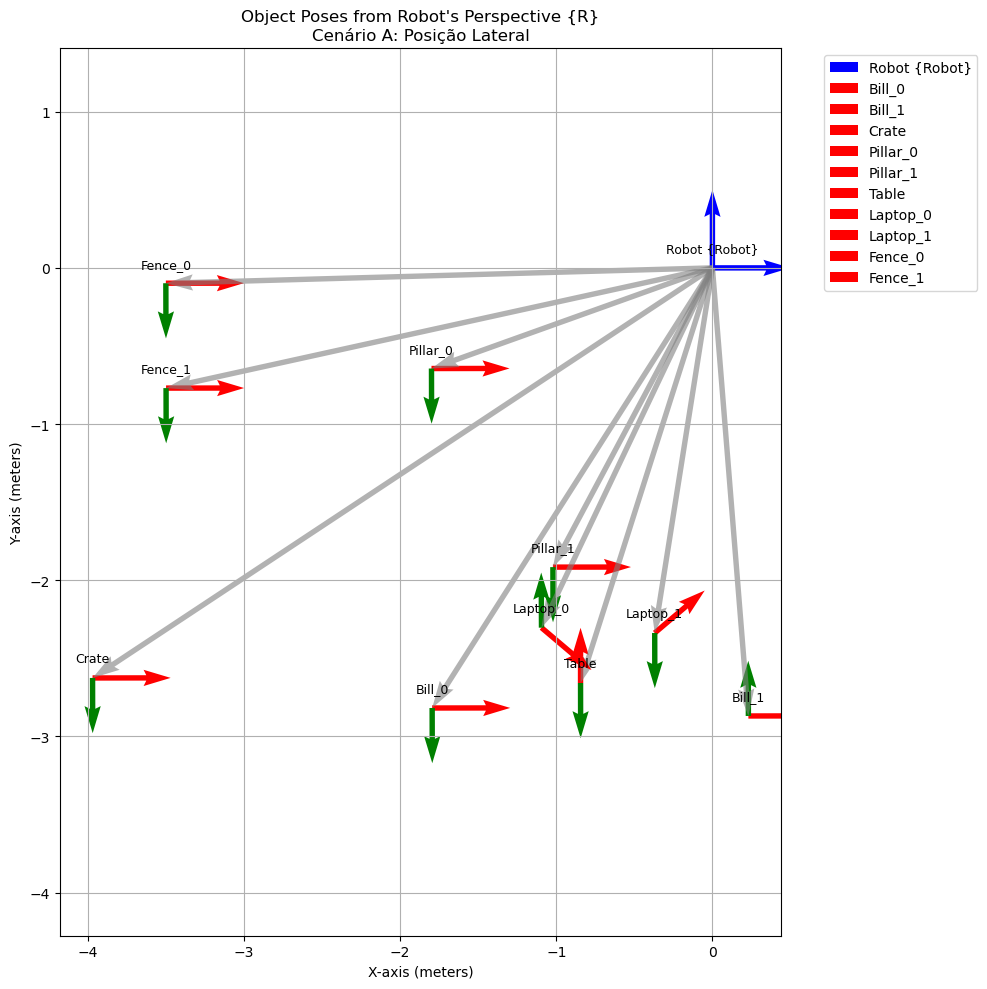

In [5]:
print("\n" + "="*60)
print("CENÁRIO A: POSIÇÃO LATERAL")
print("Mova o robô para uma posição lateral na cena e execute esta célula.")
print("="*60)


wait_for_user_input("Pressione Enter após mover o robô para a posição lateral...")

# Análise do cenário A
scenario_a_poses = analyze_scene_transformations(connector, object_handles, "Cenário A: Posição Lateral")

### Cenário B: Posição Frontal


CENÁRIO B: POSIÇÃO FRONTAL
Mova o robô para ficar de frente aos objetos principais e execute esta célula.

=== Análise de Transformações - Cenário B: Posição Frontal ===

Transformações calculadas para 10 objetos:

Bill_0:
  Posição no frame do robô: [-1.795, -3.189, -1.857] m
  Matriz válida: ✓

Bill_1:
  Posição no frame do robô: [0.230, -3.248, -1.898] m
  Matriz válida: ✓

Crate:
  Posição no frame do robô: [-3.969, -3.089, -2.397] m
  Matriz válida: ✓

Pillar_0:
  Posição no frame do robô: [-1.799, -0.695, -0.232] m
  Matriz válida: ✓

Pillar_1:
  Posição no frame do robô: [-1.021, -2.169, -1.264] m
  Matriz válida: ✓

Table:
  Posição no frame do robô: [-0.845, -3.096, -2.249] m
  Matriz válida: ✓

Laptop_0:
  Posição no frame do robô: [-1.095, -2.797, -2.592] m
  Matriz válida: ✓

Laptop_1:
  Posição no frame do robô: [-0.370, -2.836, -2.619] m
  Matriz válida: ✓

Fence_0:
  Posição no frame do robô: [-3.500, -0.062, 0.211] m
  Matriz válida: ✓

Fence_1:
  Posição no frame do r

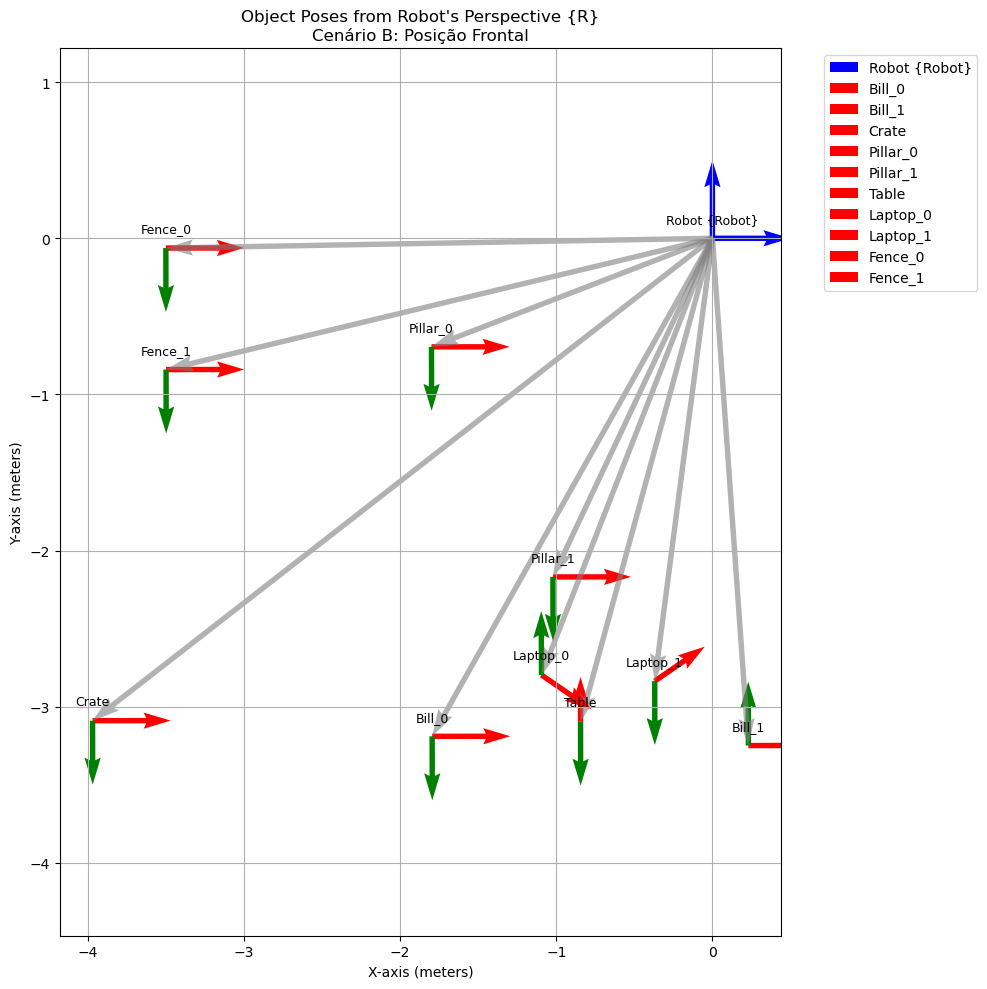

In [6]:
print("\n" + "="*60)
print("CENÁRIO B: POSIÇÃO FRONTAL")
print("Mova o robô para ficar de frente aos objetos principais e execute esta célula.")
print("="*60)

wait_for_user_input("Pressione Enter após mover o robô para a posição frontal...")

# Análise do cenário B
scenario_b_poses = analyze_scene_transformations(connector, object_handles, "Cenário B: Posição Frontal")

### Cenário C: Posição Traseira (180° de Rotação)


CENÁRIO C: POSIÇÃO TRASEIRA (180° DE ROTAÇÃO)
Mova e rotacione o robô (~180°) para ficar de costas aos objetos e execute esta célula.

=== Análise de Transformações - Cenário C: Posição Traseira (180°) ===

Transformações calculadas para 10 objetos:

Bill_0:
  Posição no frame do robô: [-1.795, 2.362, 2.836] m
  Matriz válida: ✓

Bill_1:
  Posição no frame do robô: [0.230, 2.403, 2.895] m
  Matriz válida: ✓

Crate:
  Posição no frame do robô: [-3.969, 2.083, 3.309] m
  Matriz válida: ✓

Pillar_0:
  Posição no frame do robô: [-1.799, 0.574, 0.456] m
  Matriz válida: ✓

Pillar_1:
  Posição no frame do robô: [-1.021, 1.606, 1.930] m
  Matriz válida: ✓

Table:
  Posição no frame do robô: [-0.845, 2.140, 3.173] m
  Matriz válida: ✓

Laptop_0:
  Posição no frame do robô: [-1.095, 1.741, 3.392] m
  Matriz válida: ✓

Laptop_1:
  Posição no frame do robô: [-0.370, 1.769, 3.431] m
  Matriz válida: ✓

Fence_0:
  Posição no frame do robô: [-3.500, 0.131, -0.177] m
  Matriz válida: ✓

Fence_1:
  P

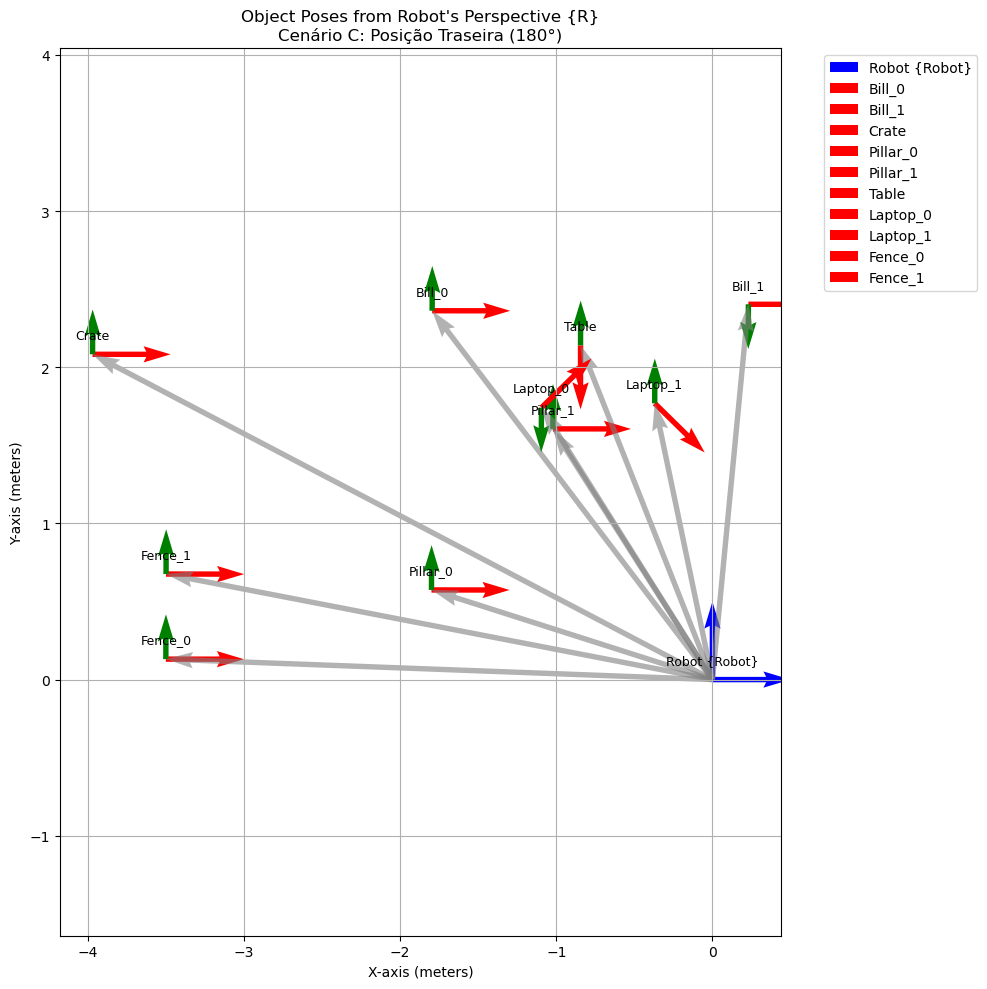

In [7]:
print("\n" + "="*60)
print("CENÁRIO C: POSIÇÃO TRASEIRA (180° DE ROTAÇÃO)")
print("Mova e rotacione o robô (~180°) para ficar de costas aos objetos e execute esta célula.")
print("="*60)

wait_for_user_input("Pressione Enter após mover o robô para a posição traseira...")

# Análise do cenário C
scenario_c_poses = analyze_scene_transformations(connector, object_handles, "Cenário C: Posição Traseira (180°)")

## Análise Comparativa dos Cenários

In [8]:
def compare_scenarios(poses_dict, object_name="Robot"):
    """
    Compara as poses de um objeto específico em diferentes cenários.
    """
    print(f"\n=== Comparação de Poses para {object_name} ===")

    scenarios = {
        'Inicial': initial_poses,
        'Lateral': scenario_a_poses if 'scenario_a_poses' in globals() else None,
        'Frontal': scenario_b_poses if 'scenario_b_poses' in globals() else None,
        'Traseira': scenario_c_poses if 'scenario_c_poses' in globals() else None
    }

    for scenario_name, poses in scenarios.items():
        if poses and object_name in poses:
            pos = poses[object_name][:3, 3]
            distance = np.linalg.norm(pos)
            print(f"{scenario_name:10}: Pos=[{pos[0]:6.3f}, {pos[1]:6.3f}, {pos[2]:6.3f}] m, Dist={distance:.3f} m")
        else:
            print(f"{scenario_name:10}: Dados não disponíveis")

# Comparar para um objeto específico
if 'Robot' in initial_poses:
    compare_scenarios(initial_poses, 'Robot')
else:
    print("Objeto Robot não encontrado para comparação")

Objeto Robot não encontrado para comparação


## Demonstração de Conceitos de Transformação

In [9]:
def demonstrate_transformation_properties():
    """
    Demonstra propriedades importantes das transformações homogêneas.
    """
    print("\n=== Demonstração de Propriedades das Transformações ===")

    # Obter poses do robô e de um objeto
    robot_pose = connector.get_object_pose('Robot')
    if not robot_pose or 'Bill_0' not in object_handles:
        print("Dados insuficientes para demonstração")
        return

    object_pose = connector.get_object_pose('Bill_0')
    if not object_pose:
        print("Não foi possível obter pose do objeto")
        return

    # Criar matrizes de transformação
    T_W_R = create_homogeneous_matrix(*robot_pose)  # Mundo -> Robô
    T_W_O = create_homogeneous_matrix(*object_pose)  # Mundo -> Objeto

    print("1. Validação de matrizes:")
    print(f"   T_W_R válida: {'✓' if validate_transformation_matrix(T_W_R) else '✗'}")
    print(f"   T_W_O válida: {'✓' if validate_transformation_matrix(T_W_O) else '✗'}")

    # Demonstrar propriedade de inversão
    T_R_W = invert_homogeneous_matrix(T_W_R)
    identity_check = T_W_R @ T_R_W
    is_identity = np.allclose(identity_check, np.eye(4), atol=1e-10)

    print("\n2. Propriedade de inversão:")
    print(f"   T_W_R @ T_R_W ≈ I: {'✓' if is_identity else '✗'}")
    print(f"   Erro máximo: {np.max(np.abs(identity_check - np.eye(4))):.2e}")

    # Demonstrar composição de transformações
    T_R_O_direct = T_R_W @ T_W_O  # Direto: Robô -> Objeto

    # Comparar com cálculo usando poses relativas
    if 'Bill_0' in initial_poses:
        T_R_O_relative = initial_poses['Bill_0']
        composition_error = np.max(np.abs(T_R_O_direct - T_R_O_relative))

        print("\n3. Composição de transformações:")
        print(f"   T_R_O (direto) ≈ T_R_O (relativo): {'✓' if composition_error < 1e-10 else '✗'}")
        print(f"   Erro máximo: {composition_error:.2e}")

    # Mostrar determinantes das matrizes de rotação
    det_R = np.linalg.det(T_W_R[:3, :3])
    det_O = np.linalg.det(T_W_O[:3, :3])

    print("\n4. Determinantes das matrizes de rotação:")
    print(f"   det(R_robô) = {det_R:.6f} (deve ser ≈ 1.0)")
    print(f"   det(R_objeto) = {det_O:.6f} (deve ser ≈ 1.0)")

# Executar demonstração
demonstrate_transformation_properties()


=== Demonstração de Propriedades das Transformações ===
1. Validação de matrizes:
   T_W_R válida: ✓
   T_W_O válida: ✓

2. Propriedade de inversão:
   T_W_R @ T_R_W ≈ I: ✓
   Erro máximo: 4.44e-16

3. Composição de transformações:
   T_R_O (direto) ≈ T_R_O (relativo): ✗
   Erro máximo: 5.22e+00

4. Determinantes das matrizes de rotação:
   det(R_robô) = 1.000000 (deve ser ≈ 1.0)
   det(R_objeto) = 1.000000 (deve ser ≈ 1.0)


## Resumo e Conclusões dos Exercícios 1-4

### Resultados Obtidos:

1. **Exercício 1**: Criação bem-sucedida de uma cena complexa no CoppeliaSim com múltiplos objetos
2. **Exercício 2**: Desenvolvimento de diagrama de transformações mostrando relações entre frames
3. **Exercício 3**: Implementação robusta de cálculos de transformações homogêneas
4. **Exercício 4**: Validação da implementação em múltiplos cenários com diferentes poses do robô

### Conceitos Aplicados:

- **Matrizes Homogêneas**: Representação unificada de rotação e translação
- **Composição de Transformações**: Cadeia de transformações entre múltiplos frames
- **Inversão Eficiente**: Uso da estrutura das matrizes homogêneas para inversão rápida
- **Validação Numérica**: Verificação de propriedades matemáticas das transformações

### Implementação Técnica:

- **Modularidade**: Código organizado em classes e funções reutilizáveis
- **Robustez**: Tratamento de erros e validação de dados
- **Visualização**: Plots informativos para análise visual dos resultados
- **Documentação**: Código bem comentado e estruturado

### Próximos Passos:

Os exercícios 5-6 estenderão este trabalho para incluir:
- Integração de sensores laser
- Transformação de dados de sensores para frame global
- Navegação autônoma com mapeamento incremental